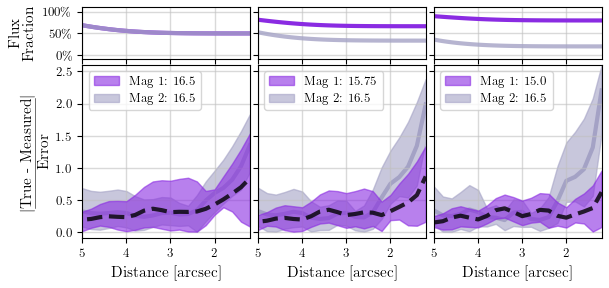

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
import numpy as np 
import glob 
from astropy.io import fits
import os

data_dir = os.getenv("DATADIR") 
plt.style.use(data_dir+'bl.mplstyle')
data_dir = data_dir + '0_SUMS_Catalogs/CompleteCatalog/'

alpha = 0.6

uvfilter = 'uvm2'
run_type = 'moving'

same_mag_files = glob.glob(data_dir+f'ClusterSims/*m1_16.5_m2_16.5_{uvfilter}_{run_type}*')
same_mag = [np.loadtxt(f) for f in same_mag_files]

# small diff
small_diff_files = glob.glob(data_dir+f'ClusterSims/*m1_15.75_m2_16.5_{uvfilter}_{run_type}*')
small_diff = [np.loadtxt(f) for f in small_diff_files]

# big diff
big_diff_files = glob.glob(data_dir+f'ClusterSims/*m1_15.0_m2_16.5_{uvfilter}_{run_type}*')
big_diff = [np.loadtxt(f) for f in big_diff_files]

df1 = pd.read_csv(data_dir+'FluxFraction/Figure5_16p5_16p5_ff_dense.csv')
df2 = pd.read_csv(data_dir+'FluxFraction/Figure5_15p75_16p5_ff_dense.csv')
df3 = pd.read_csv(data_dir+'FluxFraction/Figure5_15p0_16p5_ff_dense.csv')
ff_dfs = [df1,df2,df3]

# At each distance, which measurement is lowest and which is highest? 
# mag_index is either 1 or 2 depending on if you want mag 1 or mag 2 
def get_magdiff_range(mag_data,mag_index): 
    distance = mag_data[0][0]
    bottom_points = []
    top_points = []
    avg_points = []
    for i,d in enumerate(distance):
        points = []
        # Get the same point for each noise filter at the same distance
        for md in mag_data:
            mag = md[mag_index]
            points.append(mag[i])
        # Save the max and min of those points 
        bottom_points.append(min(points))
        top_points.append(max(points))
        avg_points.append(np.mean(points))
    return distance, bottom_points, top_points, avg_points 

dpi=200
size_high = 0.3
size_low = 1 
width = 0.3
fig_w = 3.35*2
fig_h = 3.

f = plt.figure( figsize=(fig_w, fig_h))
gs = f.add_gridspec(2, 3,  height_ratios=(size_high,size_low),width_ratios=(width,width,width))
gs.update(hspace=0.05,wspace=0.05)

top_axis = [f.add_subplot(gs[0,i]) for i in range(3)]
bottom_axis = [f.add_subplot(gs[1,i]) for i in range(3)]

 # Star 1
s1_color = 'blueviolet'
s2_color = np.array([164,162,197])/255

# Top 
for df, axs, in zip(ff_dfs,top_axis):
    axs.plot(df.distance,df.mag1_ff,color=s1_color,lw=3)    
    axs.plot(df.distance,df.mag2_ff,color=s2_color,lw=3,alpha=0.8)      
    axs.set_ylim(-0.1,1.1)
    axs.set_xlim(5,1.2)
    axs.set_yticks([0,0.5,1])
    axs.set_yticklabels([r'0\%',r'50\%',r'100\%'])
    axs.set_xticks([5,4,3,2])
    axs.set_xticklabels([]) 
    axs.grid(alpha=alpha,color='silver',lw=1)

# Bottom 
mag_values = [[16.5,16.5],[15.75,16.5],[15.0,16.5]]
for mag_data,axs,mag_value in zip([same_mag,small_diff,big_diff],bottom_axis,mag_values):
    # Get data for each test for mag1 and mag 2
    m1_d, m1_bottom, m1_top, m1_mean = get_magdiff_range(mag_data,1)
    m2_d, m2_bottom, m2_top, m2_mean = get_magdiff_range(mag_data,2)
    
    # Star 1
    axs.fill_between(m1_d, m1_bottom, m1_top,label=f'Mag 1: {mag_value[0]}',color=s1_color,alpha=alpha,zorder=2)
    axs.plot(m1_d,m1_mean,color='black',lw=3,zorder=2,alpha=0.8,ls='--')
    
    # Star 2 
    axs.fill_between(m2_d, m2_bottom, m2_top,label=f'Mag 2: {mag_value[1]}',color=s2_color,alpha=alpha,zorder=1)
    axs.plot(m2_d,m2_mean,color=s2_color,lw=3,zorder=1)

    # Admin 
    axs.set_xlabel('Distance [arcsec]')
    axs.set_xlim(5,1.2)
    axs.set_xticks([5,4,3,2])
    axs.set_ylim(-0.1,2.6)
    axs.grid(alpha=alpha,color='silver',lw=1)
    axs.legend()
    axs.legend(loc='upper left')
    
top_axis[0].set_ylabel('Flux''\nFraction')
bottom_axis[0].set_ylabel(r'$\mathrm{\mid}$'+'True - Measured'+r'$\mathrm{\mid}$'+'\nError')

# Plot line outside of the axis
ax2 = plt.axes([0.03,0.05,0.5,0.8], facecolor=(1,1,1,0))
xl = 0.048
x,y = np.array([[xl,xl], [0.2, 0.66]])
line = Line2D(x, y, lw=0.4, color='k', alpha=1)
ax2.add_line(line)
# Turn off ax2 spines
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xticks([])
ax2.set_yticks([])

[ax.set_yticklabels([]) for ax in bottom_axis[1:]]
[ax.set_yticklabels([]) for ax in top_axis[1:]]

plt.savefig(f'cluster_validation.pdf',dpi=1000,bbox_inches='tight')